# Visualizing the results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import cartogram


from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation


In [2]:
ds_path = '../../../results/batch/run_ds_18_07.nc'
ds = xr.open_dataset(ds_path)

c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
variables = ['define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact',   
       'witness_tot_eq_witness_total_impact']

#        'fund_tot_eq_monetary_impact', removed FUND because otherwise we couldn't read the other models

df = ds[variables].to_dataframe().reset_index()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

df

,time,REGIONS 35 I,define_tot_eq_define_total_impact,dice_tot_eq_dice_total_impact,witness_tot_eq_witness_total_impact
1,2005.0,BELGIUM,4.552596e+02,5.499544e+02,9.292477e+02
2,2005.0,BULGARIA,3.365703e+02,4.065775e+02,6.869865e+02
3,2005.0,CROATIA,1.805931e+02,2.181568e+02,3.686154e+02
4,2005.0,CYPRUS,3.437053e+01,4.151966e+01,7.015501e+01
5,2005.0,CZECH REPUBLIC,4.986509e+02,6.023712e+02,1.017815e+03
...,...,...,...,...,...
1955,2060.0,INDIA,1.082256e+05,5.521826e+04,9.751358e+04
1956,2060.0,LATAM,2.632613e+05,1.343197e+05,2.372041e+05
1957,2060.0,RUSSIA,5.946163e+05,3.033819e+05,5.357622e+05
1958,2060.0,USMCA,3.108425e+06,1.585964e+06,2.800758e+06


Removing weird outliers : 

In [4]:
df = df[~df['time'].isin([2015, 2043,  2048])]

In [5]:
run = df['Run'].unique()

fig, ax = plt.subplots(len(variables), len(run), figsize=(20, 15))

for j, r in enumerate(run):
    for i, v in enumerate(variables):
        sns.lineplot(data=df[df['Run'] == r], x='time', hue='REGIONS 35 I', y=v, ax=ax[i, j], legend=False)
        ax[i, j].set_title(f'Run {r}')
        ax[i, j].set_ylabel(v)
        ax[i, j].legend()

plt.tight_layout()  
plt.show()

KeyError: 'Run'

## Map showing model as a variable

Let's map ! 

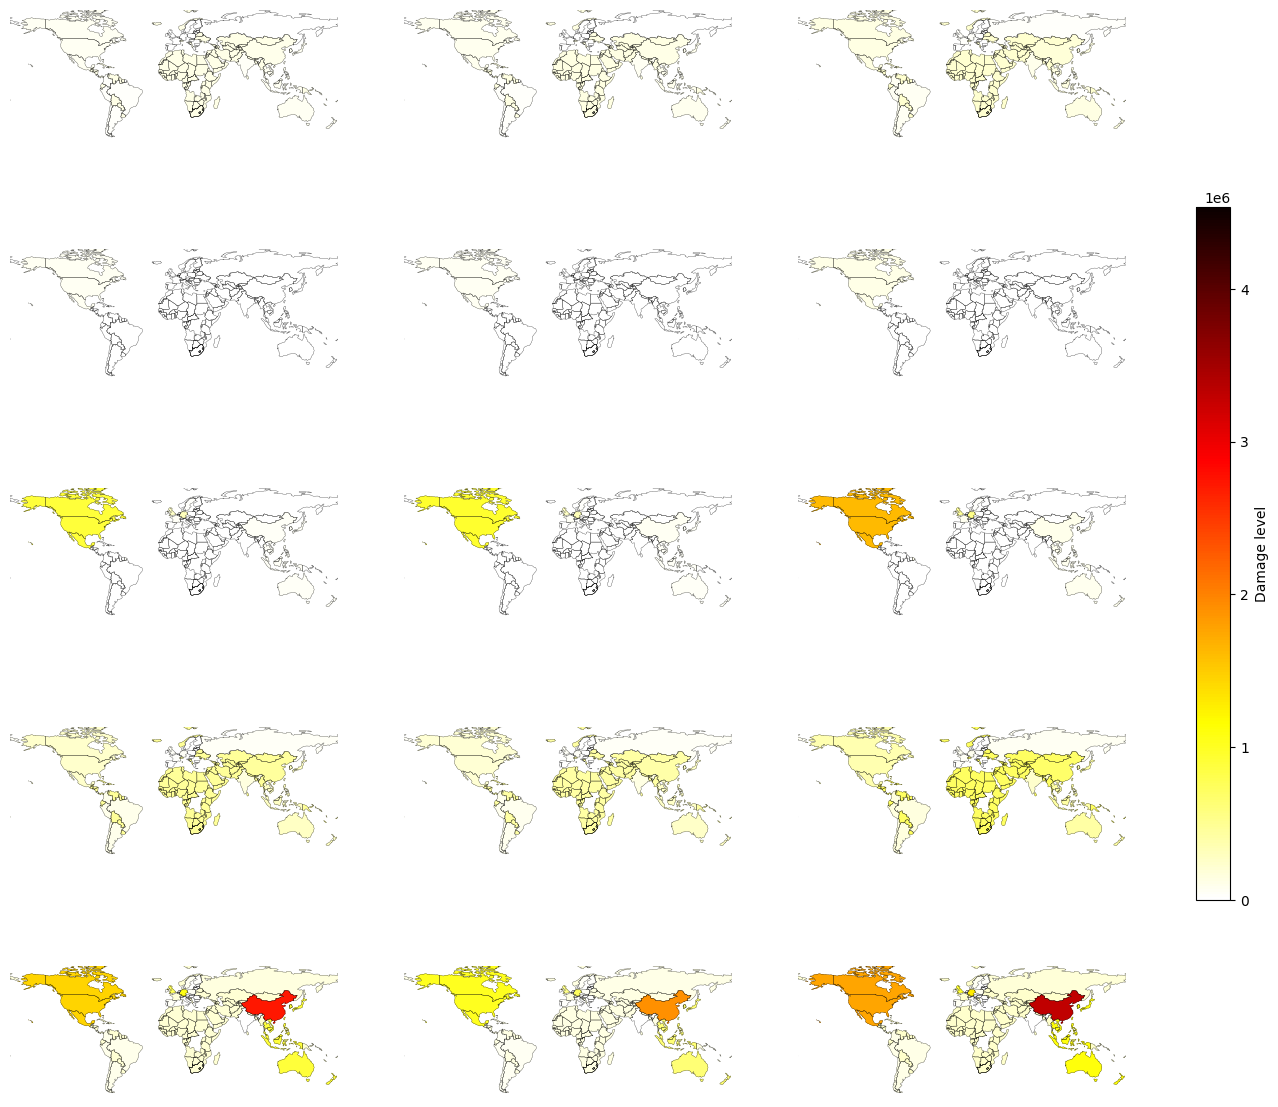

In [ ]:
decades = np.arange(2010, 2051, 10)

fig, ax = plt.subplots(len(decades), len(variables), figsize=(18, 15))

map = gpd.read_file(r'../../../WILIAM\geography\output_countries\countries.shp')

vmin = df[variables].values.min()
vmax = df[variables].values.max()


for j, r in enumerate(variables):
    for i, d in enumerate(decades):
        map_variable = map.merge(df[df['time'] == d], left_on='REGIONS 35', right_on='REGIONS 35 I')

        ax[i, j].set_axis_off()
        ax[i, j].set_xlim(-180, 180)
        ax[i, j].set_ylim(-60, 80)

        map_variable.boundary.plot(ax=ax[i, j], linewidth=0.2, color='black', alpha=0.5)
        map_variable.plot(column=r, ax= ax[i,j], cmap='hot_r', vmin=vmin, vmax=vmax)

        if j == 0:
            ax[i, j].set_ylabel(f'{d}', fontsize=12)
        
# Créer un objet Normalize pour normaliser les valeurs dans [vmin, vmax] à [0, 1]
norm = Normalize(vmin=vmin, vmax=vmax)

# Créer une ScalarMappable pour mapper les valeurs normalisées à une colormap
sm = ScalarMappable(cmap='hot_r', norm=norm)
sm.set_array([])  # Mettre un tableau vide, les données ne sont pas encore nécessaires

# Ajout d'une colorbar commune pour toutes les sous-graphiques
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Damage level')  # Définir le label de la colorbar

#plt.tight_layout()

plt.savefig('../../../figures/output.png')


## Anamorphic map (cartogram)

In [ ]:
map['WILIAM cod'].unique()

array(['LROW', 'USMCA', 'EASOC', 'LATAM', 'Russia', 'EU27', 'India',
       'China', 'UK'], dtype=object)

In [ ]:
map_variable.sort_values(by='define_tot_eq_define_total_impact', ascending=False)

,WILIAM cod,geometry,define_tot_eq_define_total_impact
5,LROW,"MULTIPOLYGON (((-55.40075 -23.95694, -55.02790...",1.063312e+08
1,EASOC,"MULTIPOLYGON (((120.29501 -10.25865, 118.96781...",7.163415e+06
8,USMCA,"MULTIPOLYGON (((-155.54211 19.08348, -155.6881...",1.409419e+06
4,LATAM,"MULTIPOLYGON (((-69.46128 -52.29195, -69.94278...",1.140659e+06
0,China,"MULTIPOLYGON (((108.62622 19.36789, 109.11906 ...",8.869077e+05
2,EU27,"MULTIPOLYGON (((-53.55484 2.33490, -53.77852 2...",3.118537e+05
3,India,"POLYGON ((97.40256 27.88254, 97.05199 27.69906...",3.030569e+05
6,Russia,"MULTIPOLYGON (((22.31572 55.01530, 22.75776 54...",8.865271e+04
7,UK,"MULTIPOLYGON (((-2.94501 53.98500, -3.61470 54...",8.314769e+04


In [ ]:
map = gpd.read_file(r'../../../WILIAM\geography\output_countries\countries.shp')    

map_variable = map.merge(df[df['time'] == 2040], left_on='REGIONS 35', right_on='REGIONS 35 I')

# Sum map variables by WILIAM regions
map_variable = map_variable.dissolve(by='WILIAM cod', aggfunc={'define_tot_eq_define_total_impact': 'sum'}).reset_index()


c = cartogram.Cartogram(map_variable, 'define_tot_eq_define_total_impact')

c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartogram\cartogram.py:268: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return self.geometry.area.sum()
c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartogram\cartogram.py:268: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return self.geometry.area.sum()
c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\cartogram\cartogram.py:268: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return self.geometry.area.sum()
c:\Users\gabriel.genel

In [ ]:
c.explore()

<GeoAxes: >

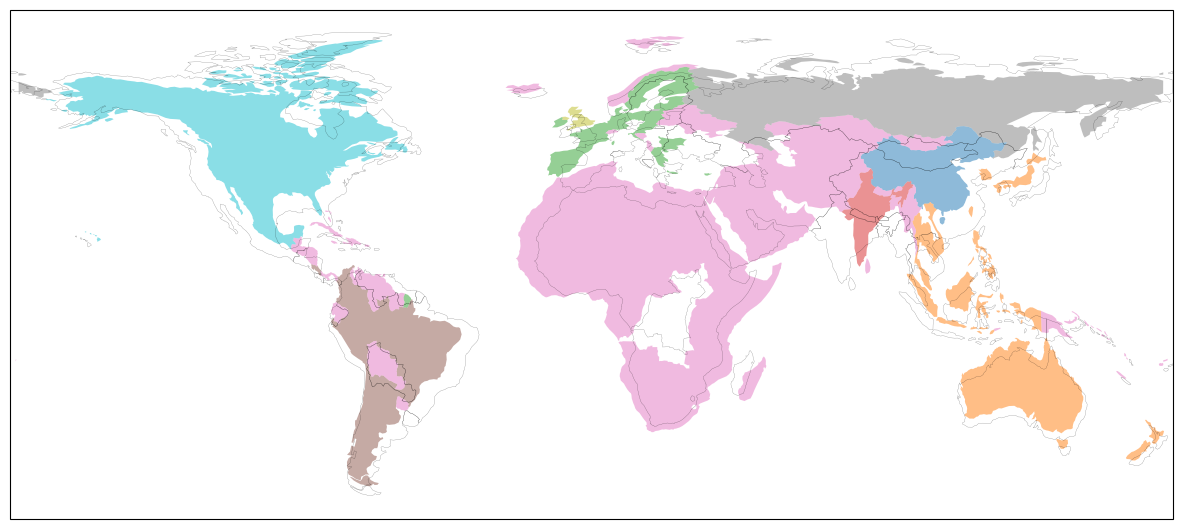

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

map_variable.boundary.plot(ax=ax, linewidth=0.2, color='black', alpha=0.5)


c.plot('WILIAM cod',  ax=ax, alpha=0.5)

In [ ]:
map = gpd.read_file(r'../../../WILIAM\geography\output_countries\countries.shp')    

map_variable = map.merge(df[df['time'] == 2040], left_on='REGIONS 35', right_on='REGIONS 35 I')

# Let's change the size of the geometries based on the level of damage
map_variable['geometry'] = map_variable.geometry.apply(lambda x: x.buffer(map_variable['define_tot_eq_define_total_impact'] * 0.1))

map_variable.plot(column='define_tot_eq_define_total_impact', cmap='hot_r', legend=True)

# Visualiser la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
map_variable.plot(ax=ax, column='define_tot_eq_define_total_impact', cmap='OrRd', legend=True)
ax.set_title('Carte en anamorphose des départements français par population')
plt.show()

C:\Users\gabriel.genelot\AppData\Local\Temp\ipykernel_40172\3993900633.py:6: UserWarning: Geometry column does not contain geometry.
  map_variable['geometry'] = map_variable.geometry.apply(lambda x: x.buffer(map_variable['define_tot_eq_define_total_impact'] * 0.1))


ValueError: Columns must be same length as key